# TAHAP 5
## Penalaran Komputer UAS
## **Anggota:**
## Haidar Dimas Heryanto - 202210370311088
## Zeedan Mustami Argani - 202210370311104

In [1]:
# Install necessary libraries
!pip install pandas requests beautifulsoup4 pdfminer.six lxml > /dev/null 2>&1

import argparse
import io
import os
import re
import time
import urllib
from concurrent.futures import ThreadPoolExecutor, wait
from datetime import date
import pandas as pd
import requests
from bs4 import BeautifulSoup
from pdfminer import high_level # For PDF text extraction
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# --- NLTK Setup (for word counting) ---
try:
    nltk.data.find('tokenizers/punkt')
    # Add this line to also check and download 'punkt_tab'
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    print("NLTK 'punkt' or 'punkt_tab' not found. Downloading...")
    nltk.download('punkt')
    nltk.download('punkt_tab') # Download the missing resource
    print("NLTK 'punkt' and 'punkt_tab' downloaded.")
except Exception as e:
     print(f"An unexpected error occurred during NLTK setup: {e}")

Mounted at /content/drive
An unexpected error occurred during NLTK setup: name 'nltk' is not defined


In [2]:
import os
import re
import pandas as pd

# --- Konfigurasi Path ---
# Pastikan path ini sesuai dengan struktur folder Anda di Google Drive
BASE_DRIVE_PATH = "/content/drive/MyDrive/Penalaran Komputer UAS/"
PATH_PROCESSED = os.path.join(BASE_DRIVE_PATH, "data/processed")
PROCESSED_CSV_FILENAME = "cases_processed.csv"
processed_data_filepath = os.path.join(PATH_PROCESSED, PROCESSED_CSV_FILENAME)

# --- Fungsi Ekstraksi dan Kategorisasi ---
def get_kategori_amar(full_text):
    """
    Mengekstrak dan mengkategorikan amar putusan dari teks lengkap sebuah dokumen.
    """
    if pd.isna(full_text) or not isinstance(full_text, str):
        return "Teks Tidak Valid"

    match = re.search(
        r"MENGADILI,?\s*(.*?)(Demikianlah diputuskan|Memperhatikan pasal-pasal)",
        full_text,
        re.IGNORECASE | re.DOTALL
    )

    if not match:
        return "Amar Tidak Ditemukan"

    amar_text = match.group(1).lower()

    if 'menolak permohonan' in amar_text:
        return "Menolak permohonan"
    elif 'mengabulkan seluruhnya' in amar_text or 'mengabulkan permohonan banding' in amar_text:
        return "Mengabulkan seluruhnya"
    elif 'mengabulkan sebagian' in amar_text:
        return "Mengabulkan sebagian"
    elif 'tidak dapat diterima' in amar_text:
        return "Tidak dapat diterima"
    else:
        return "Lain-lain (Perlu Cek Manual)"

# --- Proses Utama: Baca, Proses, dan Simpan ---
try:
    # 1. Membaca file CSV yang ada
    print(f"Membaca file dari: {processed_data_filepath}...")
    df_cases = pd.read_csv(processed_data_filepath)
    print("File berhasil dimuat.")

    # 2. Membuat kolom baru 'amar_kategori'
    print("Memproses dan membuat kolom 'amar_kategori'...")
    df_cases['amar_kategori'] = df_cases['text_full'].apply(get_kategori_amar)
    print("Kolom baru berhasil dibuat.")

    # Tampilkan beberapa baris untuk verifikasi sebelum menyimpan
    print("\nVerifikasi hasil (5 baris pertama):")
    display(df_cases[['case_id', 'amar_putusan', 'amar_kategori']].head())

    # 3. Menyimpan kembali DataFrame yang sudah diupdate ke file yang sama
    print(f"\nMenyimpan kembali DataFrame yang diperbarui ke {processed_data_filepath}...")
    df_cases.to_csv(processed_data_filepath, index=False, encoding='utf-8')
    print("✅ Berhasil! File `cases_processed.csv` telah diperbarui dengan kolom 'amar_kategori'.")

except FileNotFoundError:
    print(f"❌ Gagal: File tidak ditemukan di {processed_data_filepath}.")
    print("Pastikan file `cases_processed.csv` sudah ada dari hasil Tahap 2.")
except Exception as e:
    print(f"❌ Terjadi error: {e}")

Membaca file dari: /content/drive/MyDrive/Penalaran Komputer UAS/data/processed/cases_processed.csv...
File berhasil dimuat.
Memproses dan membuat kolom 'amar_kategori'...
Kolom baru berhasil dibuat.

Verifikasi hasil (5 baris pertama):


,case_id,amar_putusan,amar_kategori
0,case_001,Tolak,Menolak permohonan
1,case_004,Lain-lain,Menolak permohonan
2,case_005,Lain-lain,Tidak dapat diterima
3,case_009,Lain-lain,Amar Tidak Ditemukan
4,case_010,Kabul,Lain-lain (Perlu Cek Manual)



Menyimpan kembali DataFrame yang diperbarui ke /content/drive/MyDrive/Penalaran Komputer UAS/data/processed/cases_processed.csv...
✅ Berhasil! File `cases_processed.csv` telah diperbarui dengan kolom 'amar_kategori'.


In [3]:
# 05_Model_Evaluation.ipynb

import os
import pandas as pd
import numpy as np
import json
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive

In [4]:
# --- Configuration Section ---
# !!! IMPORTANT: Ensure these paths match your Google Drive structure
# and the outputs from previous notebooks !!!
BASE_DRIVE_PATH = "/content/drive/MyDrive/Penalaran Komputer UAS/" # Change to your project folder

# Paths for input data
PATH_EVAL_INPUT = os.path.join(BASE_DRIVE_PATH, "data/eval")
QUERIES_JSON_FILENAME = "queries.json" # Contains ground_truth_ids for retrieval

PATH_RESULTS_INPUT = os.path.join(BASE_DRIVE_PATH, "data/results")
PREDICTIONS_CSV_FILENAME = "predictions.csv" # Contains retrieved top_k_ids and predicted_solutions

PATH_PROCESSED_INPUT = os.path.join(BASE_DRIVE_PATH, "data/processed") # For actual case data if needed
PROCESSED_CSV_FILENAME = "cases_processed.csv"


# Path for output metrics
PATH_EVAL_OUTPUT = os.path.join(BASE_DRIVE_PATH, "data/eval") # Outputting metrics here too
RETRIEVAL_METRICS_FILENAME = "retrieval_metrics.csv"
PREDICTION_METRICS_FILENAME = "prediction_metrics.csv"

# K value for retrieval evaluation (e.g., evaluate Precision@K, Recall@K)
K_EVAL = 5 # Should match the 'k' used for generating top_k_case_ids in predictions.csv

In [5]:
# --- Helper Functions ---

def load_data_for_evaluation():
    """Loads queries, predictions, and processed cases."""
    global df_queries, df_predictions, df_cases
    queries_json_filepath = os.path.join(PATH_EVAL_INPUT, QUERIES_JSON_FILENAME)
    predictions_csv_filepath = os.path.join(PATH_RESULTS_INPUT, PREDICTIONS_CSV_FILENAME)
    cases_csv_filepath = os.path.join(PATH_PROCESSED_INPUT, PROCESSED_CSV_FILENAME)

    try:
        with open(queries_json_filepath, 'r', encoding='utf-8') as f:
            queries_data_list = json.load(f)
        df_queries = pd.DataFrame(queries_data_list)
        # Ensure ground_truth_ids is a list, even if empty
        df_queries['ground_truth_ids'] = df_queries['ground_truth_ids'].apply(lambda x: x if isinstance(x, list) else [])
        print(f"Loaded queries from: {queries_json_filepath} - {len(df_queries)} queries.")
    except FileNotFoundError:
        print(f"Error: Queries file not found at {queries_json_filepath}.")
        return False
    except Exception as e:
        print(f"Error loading queries.json: {e}")
        return False

    try:
        df_predictions = pd.read_csv(predictions_csv_filepath)
        # Convert 'top_5_case_ids' string back to list
        df_predictions['top_k_case_ids_list'] = df_predictions['top_5_case_ids'].apply(
            lambda x: [case_id.strip() for case_id in str(x).split(',')] if pd.notna(x) and str(x).strip() else []
        )
        print(f"Loaded predictions from: {predictions_csv_filepath} - {len(df_predictions)} predictions.")
    except FileNotFoundError:
        print(f"Error: Predictions file not found at {predictions_csv_filepath}.")
        return False
    except Exception as e:
        print(f"Error loading predictions.csv: {e}")
        return False

    try:
        df_cases = pd.read_csv(cases_csv_filepath)
        print(f"Loaded processed cases from: {cases_csv_filepath} - {len(df_cases)} cases.")
    except FileNotFoundError:
        print(f"Warning: Processed cases file not found at {cases_csv_filepath}. Prediction evaluation against actuals might be limited.")
        df_cases = None # Set to None if not found
    except Exception as e:
        print(f"Error loading {cases_csv_filepath}: {e}")
        df_cases = None

    return True


def calculate_retrieval_metrics_for_query(retrieved_ids, ground_truth_ids):
    """
    Calculates Precision@k, Recall@k, F1-score@k for a single query.
    k is implicitly len(retrieved_ids).
    """
    if not ground_truth_ids: # No ground truth, cannot evaluate
        return 0, 0, 0

    # Ensure retrieved_ids is a list of strings, handle empty strings or NaNs
    # This is important if top_k_case_ids_list can contain empty strings from parsing
    valid_retrieved_ids = [rid for rid in retrieved_ids if rid and pd.notna(rid)]

    if not valid_retrieved_ids: # No valid retrieved items
        return 0, 0, 0 # Precision is 0, Recall is 0 if ground truth exists but nothing retrieved

    # True positives: intersection of retrieved and ground truth
    tp_set = set(valid_retrieved_ids) & set(ground_truth_ids)
    tp = len(tp_set)

    precision_at_k = tp / len(valid_retrieved_ids) if len(valid_retrieved_ids) > 0 else 0
    recall_at_k = tp / len(ground_truth_ids) if len(ground_truth_ids) > 0 else 0
    f1_at_k = (2 * precision_at_k * recall_at_k) / (precision_at_k + recall_at_k) if (precision_at_k + recall_at_k) > 0 else 0

    return precision_at_k, recall_at_k, f1_at_k

In [6]:
# --- Tahap 5.a: Evaluasi Retrieval ---
def evaluate_retrieval_performance():
    global df_queries, df_predictions
    print("\n--- Evaluating Retrieval Performance ---")

    # Merge predictions with ground truth queries
    # Assuming query_id is the common key
    # df_predictions might have multiple rows per query_id if different algorithms were logged.
    eval_df = pd.merge(df_predictions, df_queries[['query_id', 'ground_truth_ids']], on='query_id', how='left')

    if 'ground_truth_ids' not in eval_df.columns or eval_df['ground_truth_ids'].isnull().all():
        print("Warning: 'ground_truth_ids' not found or all null in merged data. Cannot perform retrieval evaluation.")
        return pd.DataFrame() # Return empty dataframe

    retrieval_metrics_log = []
    for index, row in eval_df.iterrows():
        query_id = row['query_id']
        retrieved_ids = row['top_k_case_ids_list'][:K_EVAL] # Evaluate at K_EVAL
        ground_truth = row['ground_truth_ids']
        retrieval_method = row.get('retrieval_method', 'UNKNOWN') # Get method if logged
        prediction_algorithm = row.get('prediction_algorithm', 'UNKNOWN') # Get algo if logged

        if not isinstance(ground_truth, list) or not ground_truth: # Should be caught by apply earlier, but double check
             print(f"Warning: No ground truth for query_id {query_id}. Skipping retrieval eval for this entry.")
             precision, recall, f1 = 0,0,0
        else:
            precision, recall, f1 = calculate_retrieval_metrics_for_query(retrieved_ids, ground_truth)

        retrieval_metrics_log.append({
            'query_id': query_id,
            'retrieval_method': retrieval_method,
            'prediction_algorithm_context': prediction_algorithm, # Context of which prediction this retrieval was for
            f'precision_at_{K_EVAL}': precision,
            f'recall_at_{K_EVAL}': recall,
            f'f1_score_at_{K_EVAL}': f1
        })

    df_retrieval_metrics = pd.DataFrame(retrieval_metrics_log)

    if not df_retrieval_metrics.empty:
        # Save individual query metrics
        filepath = os.path.join(PATH_EVAL_OUTPUT, "retrieval_metrics_per_query.csv")
        df_retrieval_metrics.to_csv(filepath, index=False, encoding='utf-8')
        print(f"Per-query retrieval metrics saved to: {filepath}")
        display(df_retrieval_metrics.head())

        # Calculate and display average metrics per retrieval_method
        # We need to be careful if a query_id appears multiple times due to different prediction_algorithms
        # For now, let's average based on unique (query_id, retrieval_method) pairs if possible,
        # or just group by retrieval_method.
        # Taking the first entry per query_id if retrieval_method is the same.
        # Or, if predictions.csv has one line per (query_id, retrieval_method, prediction_algorithm)...

        # Assuming one retrieval event per (query_id, retrieval_method) if prediction_algorithm varies.
        # Let's average metrics by `retrieval_method`.
        # If `predictions.csv` has one entry per (query, retrieval_method, prediction_algo), then
        # the retrieval part is the same for entries with same query & retrieval_method.
        # So, we can drop duplicates for averaging retrieval performance for that specific retrieval method.
        cols_for_avg = [f'precision_at_{K_EVAL}', f'recall_at_{K_EVAL}', f'f1_score_at_{K_EVAL}']
        # Group by unique retrieval events to avoid double counting due to prediction algorithm variations
        unique_retrieval_events = df_retrieval_metrics.drop_duplicates(subset=['query_id', 'retrieval_method'])

        df_avg_retrieval_metrics = unique_retrieval_events.groupby('retrieval_method')[cols_for_avg].mean().reset_index()

        print("\nAverage Retrieval Metrics per Method:")
        display(df_avg_retrieval_metrics)
        filepath_avg = os.path.join(PATH_EVAL_OUTPUT, RETRIEVAL_METRICS_FILENAME) # Main summary file
        df_avg_retrieval_metrics.to_csv(filepath_avg, index=False, encoding='utf-8')
        print(f"Average retrieval metrics saved to: {filepath_avg}")
        return df_avg_retrieval_metrics
    else:
        print("No retrieval metrics were calculated.")
        return pd.DataFrame()

In [7]:
# --- Tahap 5.b: Evaluasi Prediksi (Solution Reuse) ---
# This requires ground truth for the *solution itself*, not just relevant documents.
# E.g., if predicting 'amar_putusan', we need the 'true' amar_putusan for each query.
def evaluate_prediction_performance():
    global df_queries, df_predictions, df_cases
    print("\n--- Evaluating Prediction (Solution Reuse) Performance ---")
    print("NOTE: This evaluation requires a 'ground_truth_solution' for each query.")
    print("      Please ensure your 'queries.json' (or a similar mapping) provides this.")
    print("      For example, add a field like 'expected_amar_category' to each query object.")

    # Try to merge predictions with ground truth queries, specifically looking for a 'ground_truth_solution' field
    # The 'ground_truth_solution' field is NOT standard in our current 'queries.json'.
    # This is a placeholder for how it *would* be done.
    # User needs to augment queries.json or provide this mapping.

    if 'ground_truth_solution' not in df_queries.columns:
        print("\n'ground_truth_solution' column not found in queries data (df_queries).")
        print("Prediction evaluation against ground truth solution categories cannot be performed automatically.")
        print("Consider adding a 'ground_truth_solution' or 'expected_amar_category' field to your queries.json,")
        print("or manually comparing the 'predicted_solution' in 'predictions.csv' with actuals for some cases.")
        return pd.DataFrame() # Return empty if no ground truth for solutions

    # If 'ground_truth_solution' exists:
    eval_pred_df = pd.merge(df_predictions, df_queries[['query_id', 'ground_truth_solution']], on='query_id', how='left')

    if eval_pred_df['ground_truth_solution'].isnull().all():
        print("All 'ground_truth_solution' values are null. Cannot perform prediction evaluation.")
        return pd.DataFrame()

    # Filter out rows where ground truth solution is missing for fair evaluation
    eval_pred_df_valid = eval_pred_df.dropna(subset=['ground_truth_solution', 'predicted_solution'])
    if eval_pred_df_valid.empty:
        print("No valid entries with both predicted and ground truth solutions.")
        return pd.DataFrame()

    prediction_metrics_log = []

    # Group by prediction_algorithm and retrieval_method to evaluate them separately
    grouped = eval_pred_df_valid.groupby(['retrieval_method', 'prediction_algorithm'])
    all_prediction_reports = {}

    for name, group in grouped:
        ret_method, pred_algo = name
        y_true = group['ground_truth_solution']
        y_pred = group['predicted_solution']

        if len(y_true) == 0: continue # Skip if no data for this group

        # Assuming solutions are categorical. sklearn.metrics are suitable.
        accuracy = accuracy_score(y_true, y_pred)
        # Precision, Recall, F1 per class (if multi-class) and average
        # Use zero_division=0 to handle cases where a class might not be predicted or present in y_true for small samples
        precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)
        precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=0)

        report_str = classification_report(y_true, y_pred, zero_division=0)
        all_prediction_reports[f"{ret_method}_{pred_algo}"] = report_str
        print(f"\nClassification Report for {ret_method} (Retrieval) + {pred_algo} (Prediction):")
        print(report_str)

        prediction_metrics_log.append({
            'retrieval_method': ret_method,
            'prediction_algorithm': pred_algo,
            'accuracy': accuracy,
            'precision_macro': precision_macro,
            'recall_macro': recall_macro,
            'f1_score_macro': f1_macro,
            'precision_weighted': precision_weighted,
            'recall_weighted': recall_weighted,
            'f1_score_weighted': f1_weighted,
        })

    df_prediction_metrics = pd.DataFrame(prediction_metrics_log)

    if not df_prediction_metrics.empty:
        display(df_prediction_metrics)
        filepath = os.path.join(PATH_EVAL_OUTPUT, PREDICTION_METRICS_FILENAME)
        df_prediction_metrics.to_csv(filepath, index=False, encoding='utf-8')
        print(f"Prediction metrics saved to: {filepath}")
        # Save detailed classification reports too
        with open(os.path.join(PATH_EVAL_OUTPUT, "prediction_classification_reports.txt"), "w", encoding="utf-8") as f:
            for name, report in all_prediction_reports.items():
                f.write(f"--- Report for: {name} ---\n")
                f.write(report)
                f.write("\n\n")
        print(f"Detailed classification reports saved to prediction_classification_reports.txt")

        return df_prediction_metrics
    else:
        print("No prediction metrics were calculated (likely due to missing ground_truth_solution).")
        return pd.DataFrame()

In [8]:
# --- Tahap 5.c: Visualisasi & Laporan (Analisis Kegagalan) ---
def visualize_and_analyze(df_avg_retrieval_metrics, df_prediction_metrics):
    print("\n--- Visualizing Performance ---")

    # Plot Retrieval Metrics (Optional)
    if df_avg_retrieval_metrics is not None and not df_avg_retrieval_metrics.empty:
        df_avg_retrieval_metrics.set_index('retrieval_method', inplace=True)
        df_avg_retrieval_metrics.plot(kind='bar', figsize=(12, 7), colormap='viridis')
        plt.title(f'Average Retrieval Performance @ K={K_EVAL}')
        plt.ylabel('Score')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(os.path.join(PATH_EVAL_OUTPUT, 'retrieval_performance_chart.png'))
        plt.show()
        df_avg_retrieval_metrics.reset_index(inplace=True) # Reset index for consistency

    # Plot Prediction Metrics (Optional)
    if df_prediction_metrics is not None and not df_prediction_metrics.empty:
        # Plotting accuracy and F1-macro for different prediction setups
        plot_df = df_prediction_metrics.set_index(['retrieval_method', 'prediction_algorithm'])[['accuracy', 'f1_score_macro']]
        plot_df.plot(kind='bar', figsize=(14, 8), colormap='coolwarm')
        plt.title('Prediction Performance (Accuracy & F1-Macro)')
        plt.ylabel('Score')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig(os.path.join(PATH_EVAL_OUTPUT, 'prediction_performance_chart.png'))
        plt.show()


    print("\n--- Analisis Kegagalan (Error Analysis / Rejection) ---") #
    print("This section requires manual inspection of cases where the model performed poorly.")
    print("Steps for Error Analysis:")
    print("1. Identify Queries with Poor Retrieval: Look at 'retrieval_metrics_per_query.csv'. Filter for queries with low F1-score.")
    print("   Example: `df_retrieval_metrics[df_retrieval_metrics[f'f1_score_at_{K_EVAL}'] < 0.3]`")
    print("2. For these queries:")
    print("   a. Examine the query text.")
    print("   b. Compare 'top_k_case_ids_list' (retrieved by your system) with 'ground_truth_ids'.")
    print("   c. Read the content (e.g., 'ringkasan_fakta', 'amar_putusan') of both retrieved and ground truth cases from 'cases_processed.csv'.")
    print("3. Hypothesize Reasons for Failure:")
    print("   - Query Ambiguity: Is the query too vague or too specific?")
    print("   - Vocabulary Mismatch (TF-IDF): Does the query use different terms than relevant documents?")
    print("   - Lack of Semantic Understanding (TF-IDF): Does TF-IDF fail to capture deeper meaning?")
    print("   - BERT Limitations: Is the query out-of-domain for BERT's training? Is context handled well?")
    print("   - Data Quality: Are there issues in the text of the documents (e.g. OCR errors, boilerplate)?")
    print("   - Ground Truth Issues: Are the 'ground_truth_ids' definitely correct and comprehensive?")
    print("4. Analyze Poor Predictions (if prediction evaluation was possible):")
    print("   - If `predicted_solution` is wrong, why? Was it due to poor retrieval (wrong similar cases found)?")
    print("   - Or was the prediction algorithm (majority_vote, weighted_similarity) flawed for that specific set of retrieved solutions?")
    print("5. Document Findings and Suggest Improvements:")
    print("   - E.g., improve text preprocessing, use query expansion, fine-tune BERT, add more features, improve solution aggregation logic.") #
    print("\nExample: To get details for a poorly performing query 'QXXX':")
    # print("   `poor_query_details = df_predictions[df_predictions['query_id'] == 'QXXX']`")
    # print("   `display(poor_query_details)`")
    # print("   `ground_truth_for_poor_query = df_queries[df_queries['query_id'] == 'QXXX']['ground_truth_ids'].iloc[0]`")
    # print("   `print(f'Ground truth: {ground_truth_for_poor_query}')`")
    # print("   # Then look up these case_ids in df_cases")

Starting Tahap 5: Model Evaluation
Mounted at /content/drive
Loaded queries from: /content/drive/MyDrive/Penalaran Komputer UAS/data/eval/queries.json - 7 queries.
Loaded predictions from: /content/drive/MyDrive/Penalaran Komputer UAS/data/results/predictions.csv - 10 predictions.
Loaded processed cases from: /content/drive/MyDrive/Penalaran Komputer UAS/data/processed/cases_processed.csv - 50 cases.

--- Evaluating Retrieval Performance ---
Per-query retrieval metrics saved to: /content/drive/MyDrive/Penalaran Komputer UAS/data/eval/retrieval_metrics_per_query.csv


,query_id,retrieval_method,prediction_algorithm_context,precision_at_5,recall_at_5,f1_score_at_5
0,Q001_PO,tfidf,majority_vote,0.4,0.4,0.400000
1,Q001_PO,tfidf,weighted_similarity,0.4,0.4,0.400000
2,Q002_PO,tfidf,majority_vote,0.2,0.5,0.285714
3,Q002_PO,tfidf,weighted_similarity,0.2,0.5,0.285714
4,Q003_PO,tfidf,majority_vote,0.0,0.0,0.000000



Average Retrieval Metrics per Method:


,retrieval_method,precision_at_5,recall_at_5,f1_score_at_5
0,tfidf,0.2,0.224444,0.194286


Average retrieval metrics saved to: /content/drive/MyDrive/Penalaran Komputer UAS/data/eval/retrieval_metrics.csv

--- Evaluating Prediction (Solution Reuse) Performance ---
NOTE: This evaluation requires a 'ground_truth_solution' for each query.
      Please ensure your 'queries.json' (or a similar mapping) provides this.
      For example, add a field like 'expected_amar_category' to each query object.

Classification Report for tfidf (Retrieval) + majority_vote (Prediction):
                             precision    recall  f1-score   support

         Menolak Permohonan       0.00      0.00      0.00       5.0
NO_VALID_SOLUTIONS_IN_TOP_K       0.00      0.00      0.00       0.0

                   accuracy                           0.00       5.0
                  macro avg       0.00      0.00      0.00       5.0
               weighted avg       0.00      0.00      0.00       5.0


Classification Report for tfidf (Retrieval) + weighted_similarity (Prediction):
                   

,retrieval_method,prediction_algorithm,accuracy,precision_macro,recall_macro,f1_score_macro,precision_weighted,recall_weighted,f1_score_weighted
0,tfidf,majority_vote,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,tfidf,weighted_similarity,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Prediction metrics saved to: /content/drive/MyDrive/Penalaran Komputer UAS/data/eval/prediction_metrics.csv
Detailed classification reports saved to prediction_classification_reports.txt

--- Visualizing Performance ---


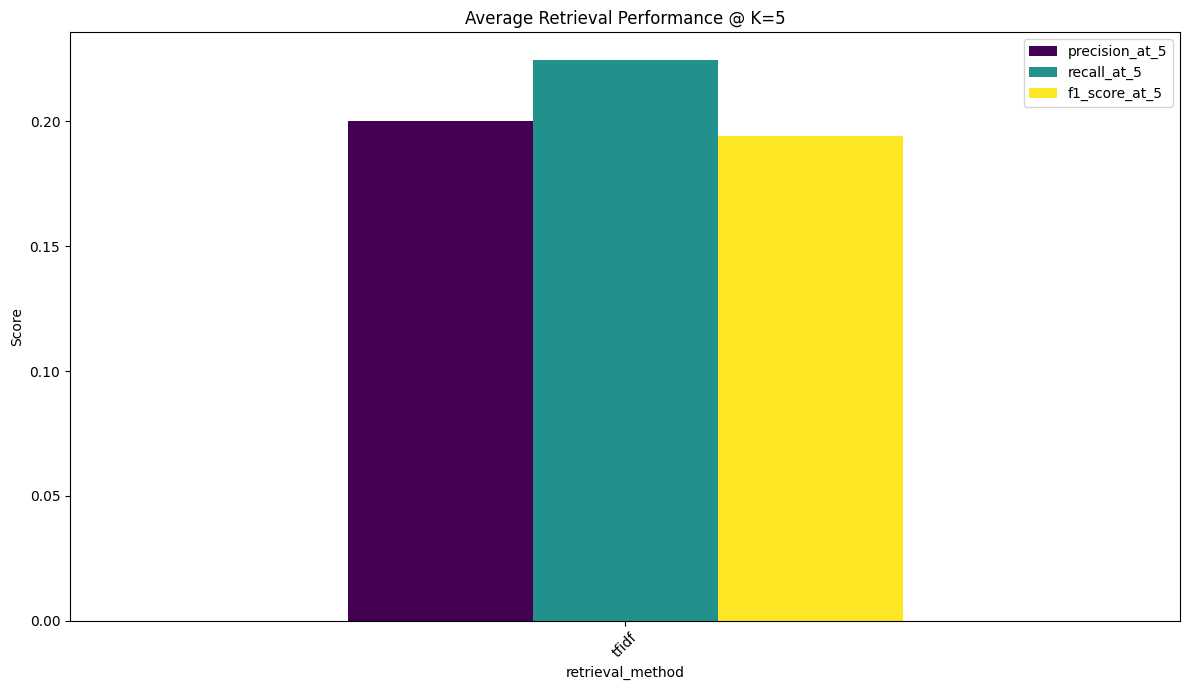

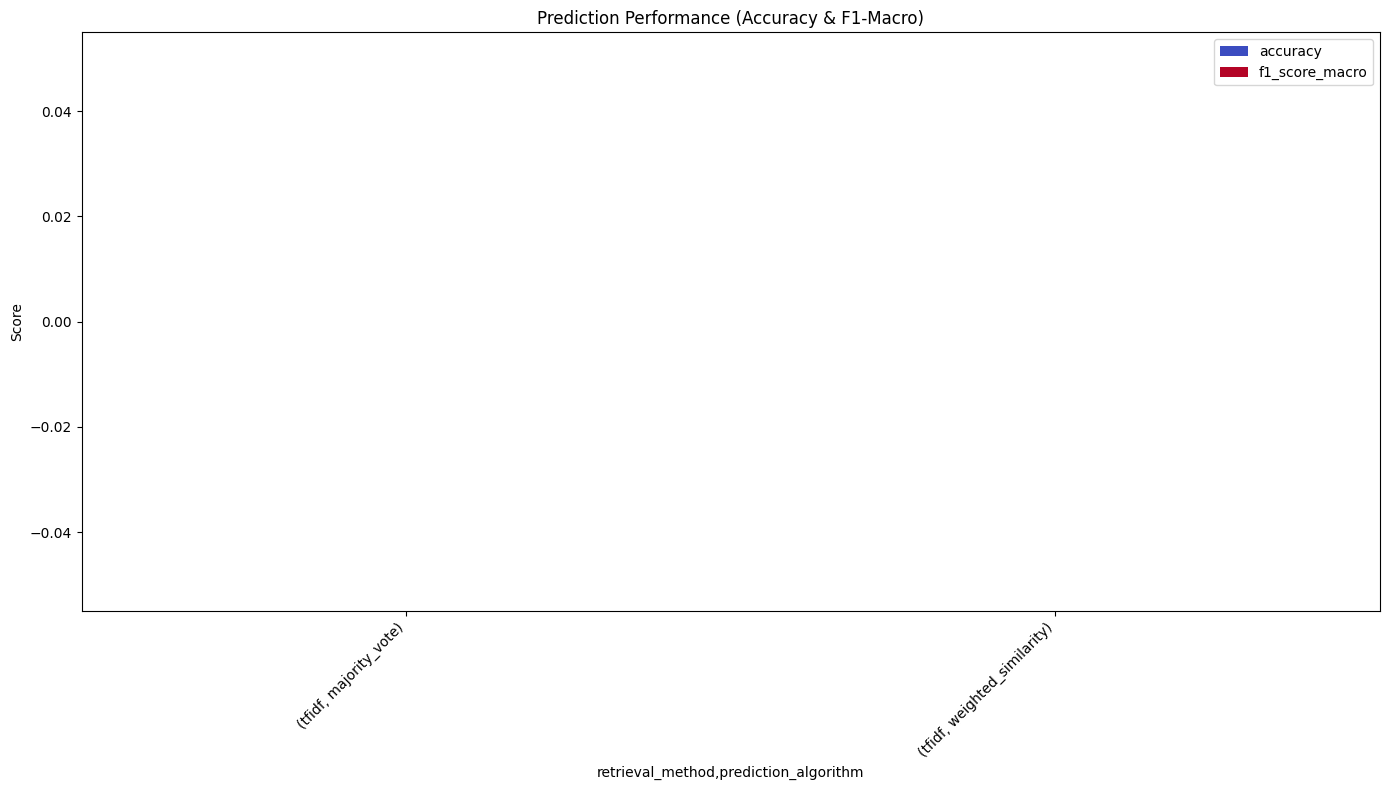


--- Analisis Kegagalan (Error Analysis / Rejection) ---
This section requires manual inspection of cases where the model performed poorly.
Steps for Error Analysis:
1. Identify Queries with Poor Retrieval: Look at 'retrieval_metrics_per_query.csv'. Filter for queries with low F1-score.
   Example: `df_retrieval_metrics[df_retrieval_metrics[f'f1_score_at_{K_EVAL}'] < 0.3]`
2. For these queries:
   a. Examine the query text.
   b. Compare 'top_k_case_ids_list' (retrieved by your system) with 'ground_truth_ids'.
   c. Read the content (e.g., 'ringkasan_fakta', 'amar_putusan') of both retrieved and ground truth cases from 'cases_processed.csv'.
3. Hypothesize Reasons for Failure:
   - Query Ambiguity: Is the query too vague or too specific?
   - Vocabulary Mismatch (TF-IDF): Does the query use different terms than relevant documents?
   - Lack of Semantic Understanding (TF-IDF): Does TF-IDF fail to capture deeper meaning?
   - BERT Limitations: Is the query out-of-domain for BERT's traini

In [9]:
# --- Main Execution ---
if __name__ == "__main__":
    print("Starting Tahap 5: Model Evaluation")
    drive.mount('/content/drive', force_remount=True)

    if load_data_for_evaluation():
        df_avg_ret_metrics = evaluate_retrieval_performance()
        df_pred_metrics = evaluate_prediction_performance() # This might return empty if no ground_truth_solution
        visualize_and_analyze(df_avg_ret_metrics, df_pred_metrics)
    else:
        print("Failed to load necessary data. Evaluation cannot proceed.")

    print("\nTahap 5: Model Evaluation - Complete.")